# Relative Thumb movement analysis

As a step up from [neuro-breakout](https://github.com/PerlinWarp/Neuro-Breakout) and trying to use the leap motion, 30 seconds of data has been gathered using the hand. 

### Review of the last model
The thumb model explored in 1-ThumbAnalysis would never completely work in production because the distance of the thumb to the leap motion changes. I would have to instead consider either the angles of the thumb or the relative position of the thumb to a known point. We can see how this model performed in the gif below:


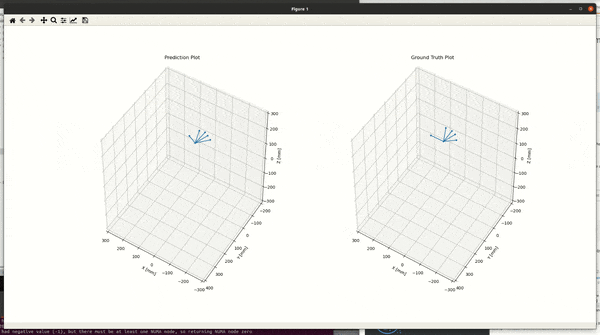



In this notebook, I will try to predict the position of the thumb from the palm. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Thumb data was gathered on April 7th, at 16:30 using [this](https://github.com/PerlinWarp/NeuroLeap/commit/09cba969eb64a9da1b9b925f458650e208ae997f) commit.

Important parts of this commit was that data was gathered using:
```
m = MyoRaw(raw=False, filtered=True) # 50Hz Filtered Myo data

	def get_points():
		frame = controller.frame()
		hand = frame.hands.rightmost
		if not hand.is_valid: return None
		fingers = hand.fingers

		X = []
		Y = []
		Z = []

		# Add the position of the palms
		X.append(-1 *hand.palm_position.x)
		Y.append(hand.palm_position.y)
		Z.append(hand.palm_position.z)

		for finger in fingers:
			# Add finger tip positions
			X.append(-1 * finger.stabilized_tip_position.x)
			Y.append(finger.stabilized_tip_position.y)
			Z.append(finger.stabilized_tip_position.z) 
		return np.array([X, Z, Y])

```

Note the **stabilized tip positions** from the [documentation](https://developer-archive.leapmotion.com/documentation/python/api/Leap.Pointable.html#Leap.Pointable.stabilized_tip_position):
  
Smoothing and stabilization is performed in order to make this value more suitable for interaction with 2D content. The stabilized position lags behind the tip position by a variable amount, depending primarily on the speed of movement.


In [2]:
data = pd.read_csv("thumb_dataset_30.csv")

In [3]:
data.head()

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Palm_tip_x,Thumb_tip_x,...,Index_tip_y,Middle_tip_y,Ring_tip_y,Pinky_tip_y,Palm_tip_z,Thumb_tip_z,Index_tip_z,Middle_tip_z,Ring_tip_z,Pinky_tip_z
0,31,140,140,83,42,30,22,21,-18.167004,27.724434,...,-73.758804,-89.471649,-79.439949,-71.918144,144.981094,120.059906,133.536011,124.068176,119.804108,109.158684
1,30,154,193,89,53,31,21,21,-18.131498,27.894018,...,-73.705612,-89.391991,-79.372650,-71.772514,144.968231,120.200348,133.561554,124.106369,119.839752,109.234200
2,31,159,193,89,57,33,27,28,-18.109987,28.061665,...,-73.654808,-89.311295,-79.303879,-71.628952,144.953217,120.337166,133.585297,124.143944,119.874626,109.307076
3,33,152,177,96,58,34,27,30,-18.092686,28.231144,...,-73.604759,-89.231735,-79.234291,-71.495186,144.924377,120.473526,133.607986,124.180008,119.908142,109.373688
4,30,134,182,88,56,34,29,30,-18.089689,28.402817,...,-73.555382,-89.153038,-79.166466,-71.375092,144.883591,120.609833,133.629761,124.214531,119.939423,109.432350


<AxesSubplot:>

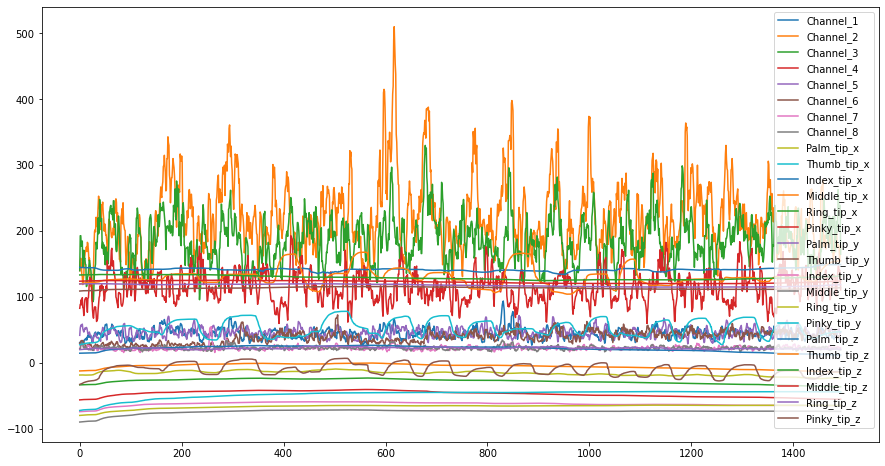

In [4]:
plt.rc('figure', figsize=(15, 8))

data.plot()

In [5]:
data.columns

Index(['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8', 'Palm_tip_x', 'Thumb_tip_x',
       'Index_tip_x', 'Middle_tip_x', 'Ring_tip_x', 'Pinky_tip_x',
       'Palm_tip_y', 'Thumb_tip_y', 'Index_tip_y', 'Middle_tip_y',
       'Ring_tip_y', 'Pinky_tip_y', 'Palm_tip_z', 'Thumb_tip_z', 'Index_tip_z',
       'Middle_tip_z', 'Ring_tip_z', 'Pinky_tip_z'],
      dtype='object')

<AxesSubplot:>

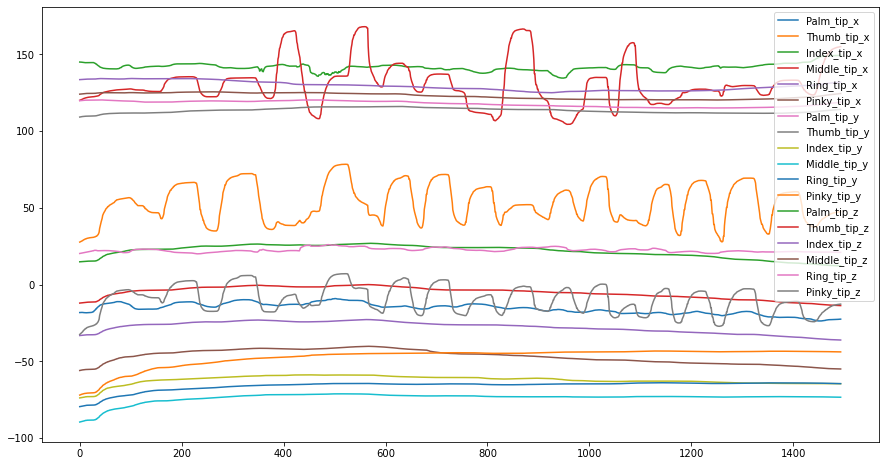

In [6]:
# Just considering the position data
pos_cols = ['Palm_tip_x', 'Thumb_tip_x',
       'Index_tip_x', 'Middle_tip_x', 'Ring_tip_x', 'Pinky_tip_x',
       'Palm_tip_y', 'Thumb_tip_y', 'Index_tip_y', 'Middle_tip_y',
       'Ring_tip_y', 'Pinky_tip_y', 'Palm_tip_z', 'Thumb_tip_z', 'Index_tip_z',
       'Middle_tip_z', 'Ring_tip_z', 'Pinky_tip_z']

df = data[pos_cols]
df.plot()

<AxesSubplot:>

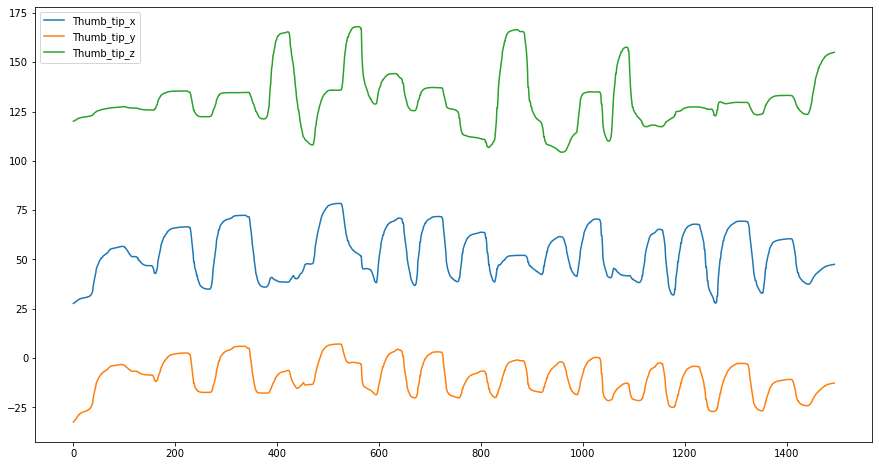

In [7]:
# Just considering the thumb
cols = ['Thumb_tip_x', 'Thumb_tip_y', 'Thumb_tip_z']
df = data[cols]
df.plot()

In [8]:
data.var()

Channel_1         61.155101
Channel_2       2981.336682
Channel_3       1252.896925
Channel_4        504.741145
Channel_5         47.501323
Channel_6         76.654646
Channel_7         10.194760
Channel_8          6.626612
Palm_tip_x        12.398094
Thumb_tip_x      155.309039
Index_tip_x       16.549957
Middle_tip_x      14.101624
Ring_tip_x        13.377871
Pinky_tip_x       19.356980
Palm_tip_y         1.829982
Thumb_tip_y       80.012689
Index_tip_y        7.472674
Middle_tip_y      10.030366
Ring_tip_y         9.116989
Pinky_tip_y       36.370002
Palm_tip_z         5.673768
Thumb_tip_z      197.256755
Index_tip_z        8.645685
Middle_tip_z       3.685747
Ring_tip_z         3.382069
Pinky_tip_z        2.506600
dtype: float64

By looking at the variance, we can make sure we didn't move the arm around too much.

In [9]:
data.columns

Index(['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8', 'Palm_tip_x', 'Thumb_tip_x',
       'Index_tip_x', 'Middle_tip_x', 'Ring_tip_x', 'Pinky_tip_x',
       'Palm_tip_y', 'Thumb_tip_y', 'Index_tip_y', 'Middle_tip_y',
       'Ring_tip_y', 'Pinky_tip_y', 'Palm_tip_z', 'Thumb_tip_z', 'Index_tip_z',
       'Middle_tip_z', 'Ring_tip_z', 'Pinky_tip_z'],
      dtype='object')

From now on, I will only use sEMG, thumb and palm data. The palm data is to use as a reference. 

<AxesSubplot:>

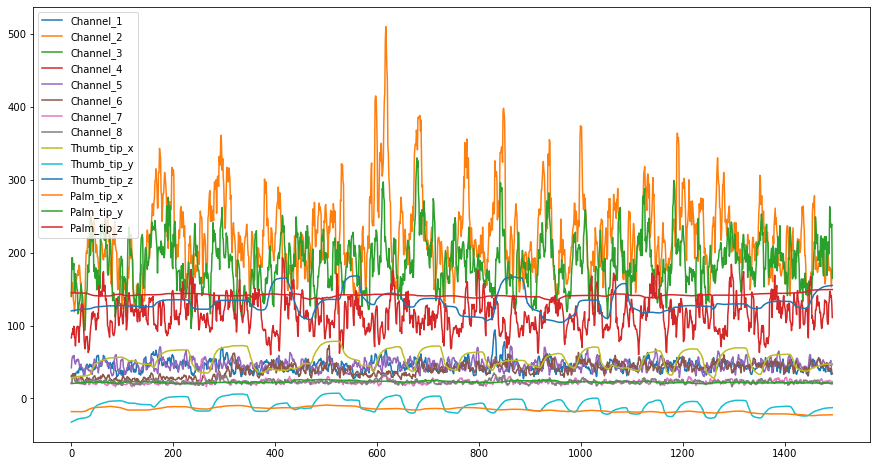

In [10]:
# Just considering the data we care about
cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8','Thumb_tip_x', 'Thumb_tip_y', 'Thumb_tip_z', 
       'Palm_tip_x', 'Palm_tip_y', 'Palm_tip_z']
df = data[cols]
df.plot()

[Text(0.5, 1.0, 'sEMG and Leap corrolations')]

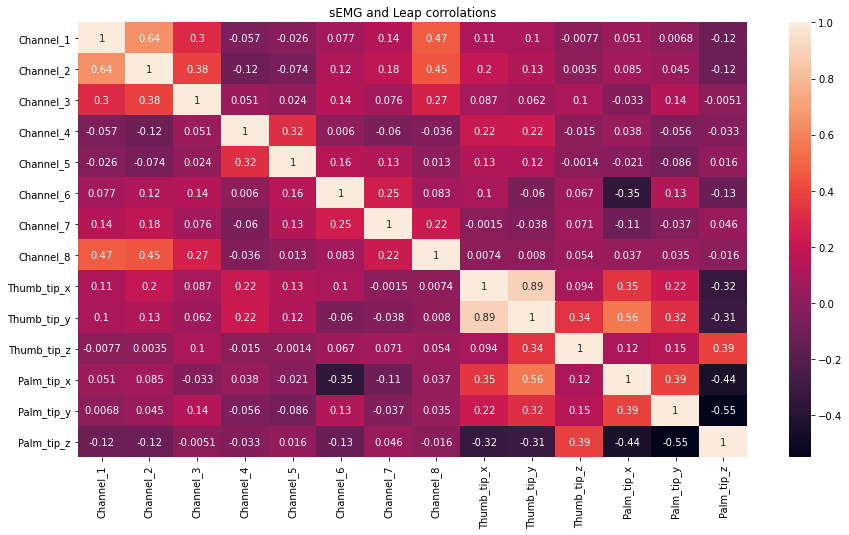

In [11]:
sns.heatmap(df.corr(), annot=True).set(title="sEMG and Leap corrolations")

# Feature engineering: relative positions

In [12]:
df.columns

Index(['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8', 'Thumb_tip_x', 'Thumb_tip_y',
       'Thumb_tip_z', 'Palm_tip_x', 'Palm_tip_y', 'Palm_tip_z'],
      dtype='object')

<ipython-input-13-69a715ef4de4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rel["Thumb_r_tip_x"] = df_rel["Thumb_tip_x"] - df_rel['Palm_tip_x']
<ipython-input-13-69a715ef4de4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rel["Thumb_r_tip_y"] = df_rel["Thumb_tip_y"] - df_rel['Palm_tip_y']
<ipython-input-13-69a715ef4de4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

[Text(0.5, 1.0, 'sEMG and Leap rel corrolations')]

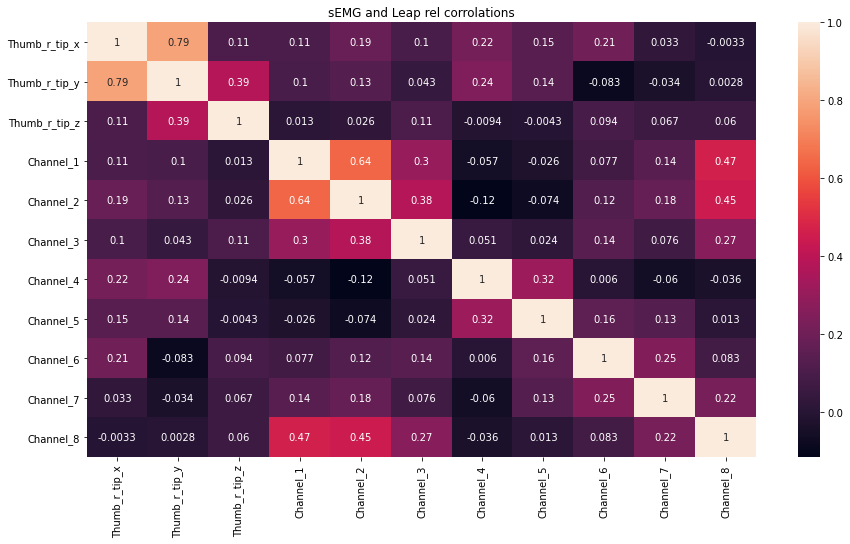

In [13]:
df_rel = df
df_rel["Thumb_r_tip_x"] = df_rel["Thumb_tip_x"] - df_rel['Palm_tip_x']
df_rel["Thumb_r_tip_y"] = df_rel["Thumb_tip_y"] - df_rel['Palm_tip_y']
df_rel["Thumb_r_tip_z"] = df_rel["Thumb_tip_z"] - df_rel['Palm_tip_z']

df_rel = df_rel[['Thumb_r_tip_x', 'Thumb_r_tip_y','Thumb_r_tip_z',
                 'Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
                 'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']]

sns.heatmap(df_rel.corr(), annot=True).set(title="sEMG and Leap rel corrolations")

[Text(0.5, 1.0, 'sEMG and Leap rel corrolations')]

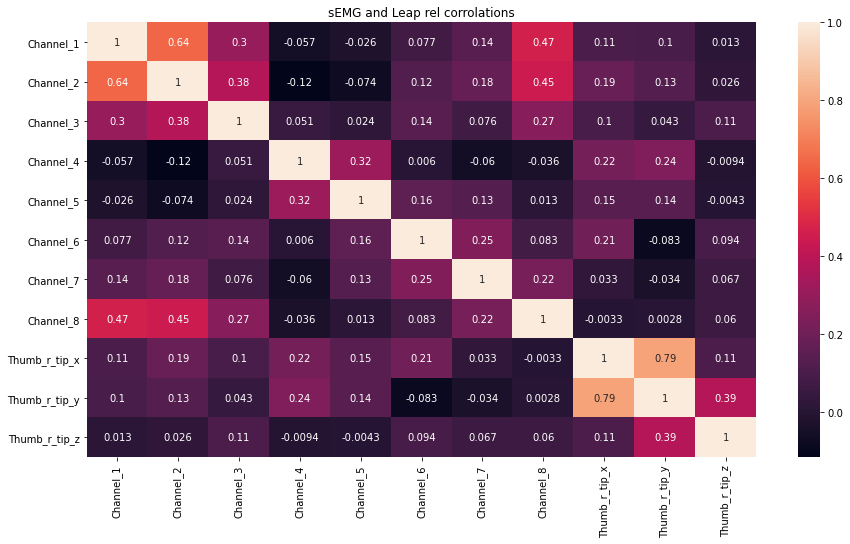

In [14]:
df_rel = df_rel[['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
                 'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8', 
                 'Thumb_r_tip_x', 'Thumb_r_tip_y','Thumb_r_tip_z']]

sns.heatmap(df_rel.corr(), annot=True).set(title="sEMG and Leap rel corrolations")

# Making some baseline ML

## Train Test Split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
y_cols = ['Thumb_r_tip_x', 'Thumb_r_tip_y','Thumb_r_tip_z']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']

y = df_rel['Thumb_r_tip_x']
X = df_rel[x_cols]
train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

In [17]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

predictions = my_model.predict(test_X)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error X: " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error X: 7.677097238958838


In [18]:
y_cols = ['Thumb_r_tip_x', 'Thumb_r_tip_y','Thumb_r_tip_z']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']

y = df['Thumb_r_tip_x']
X = df[x_cols]
train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

predictions = my_model.predict(test_X)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error Y: " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error Y: 8.04792838938096


In [19]:
y_cols = ['Thumb_r_tip_x', 'Thumb_r_tip_y','Thumb_r_tip_z']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']

y = df['Thumb_r_tip_z']
X = df[x_cols]
train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

predictions = my_model.predict(test_X)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error Z: " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error Z: 8.499764301321086


We can see that using the relative position does not make the model much better. 

# Multivariate regression

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [21]:
y_cols = ['Thumb_r_tip_x', 'Thumb_r_tip_y','Thumb_r_tip_z']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']

y = df_rel[y_cols]
X = df_rel[x_cols]
train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

In [22]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(8, kernel_initializer='normal',input_dim = train_X.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(3, kernel_initializer='normal'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2304      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 68,939
Trainable params: 68,939
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = NN_model.fit(train_X, train_y, epochs=500, batch_size=32, validation_split = 0.2)

Epoch 1/500
28/28 [==============================] - 0s 4ms/step - loss: 25.0675 - mean_absolute_error: 25.0675 - val_loss: 11.6621 - val_mean_absolute_error: 11.6621
Epoch 2/500
28/28 [==============================] - 0s 2ms/step - loss: 10.6613 - mean_absolute_error: 10.6613 - val_loss: 10.3195 - val_mean_absolute_error: 10.3195
Epoch 3/500
28/28 [==============================] - 0s 2ms/step - loss: 9.9706 - mean_absolute_error: 9.9706 - val_loss: 10.0197 - val_mean_absolute_error: 10.0197
Epoch 4/500
28/28 [==============================] - 0s 2ms/step - loss: 9.7365 - mean_absolute_error: 9.7365 - val_loss: 9.7772 - val_mean_absolute_error: 9.7772
Epoch 5/500
28/28 [==============================] - 0s 2ms/step - loss: 9.5681 - mean_absolute_error: 9.5681 - val_loss: 9.6837 - val_mean_absolute_error: 9.6837
Epoch 6/500
28/28 [==============================] - 0s 2ms/step - loss: 9.4811 - mean_absolute_error: 9.4811 - val_loss: 9.4911 - val_mean_absolute_error: 9.4911
Epoch 7/500


Epoch 51/500
28/28 [==============================] - 0s 2ms/step - loss: 8.9678 - mean_absolute_error: 8.9678 - val_loss: 9.3034 - val_mean_absolute_error: 9.3034
Epoch 52/500
28/28 [==============================] - 0s 2ms/step - loss: 8.9700 - mean_absolute_error: 8.9700 - val_loss: 9.2186 - val_mean_absolute_error: 9.2186
Epoch 53/500
28/28 [==============================] - 0s 2ms/step - loss: 8.8698 - mean_absolute_error: 8.8698 - val_loss: 9.1294 - val_mean_absolute_error: 9.1294
Epoch 54/500
28/28 [==============================] - 0s 2ms/step - loss: 8.9272 - mean_absolute_error: 8.9272 - val_loss: 9.2074 - val_mean_absolute_error: 9.2074
Epoch 55/500
28/28 [==============================] - 0s 2ms/step - loss: 8.9267 - mean_absolute_error: 8.9267 - val_loss: 9.1478 - val_mean_absolute_error: 9.1478
Epoch 56/500
28/28 [==============================] - 0s 2ms/step - loss: 8.8895 - mean_absolute_error: 8.8895 - val_loss: 9.1039 - val_mean_absolute_error: 9.1039
Epoch 57/500
28/

Epoch 101/500
28/28 [==============================] - 0s 2ms/step - loss: 8.5184 - mean_absolute_error: 8.5184 - val_loss: 9.2066 - val_mean_absolute_error: 9.2066
Epoch 102/500
28/28 [==============================] - 0s 2ms/step - loss: 8.5692 - mean_absolute_error: 8.5692 - val_loss: 9.6290 - val_mean_absolute_error: 9.6290
Epoch 103/500
28/28 [==============================] - 0s 2ms/step - loss: 8.6330 - mean_absolute_error: 8.6330 - val_loss: 9.0184 - val_mean_absolute_error: 9.0184
Epoch 104/500
28/28 [==============================] - 0s 2ms/step - loss: 8.5773 - mean_absolute_error: 8.5773 - val_loss: 9.0822 - val_mean_absolute_error: 9.0822
Epoch 105/500
28/28 [==============================] - 0s 2ms/step - loss: 8.5264 - mean_absolute_error: 8.5264 - val_loss: 8.9491 - val_mean_absolute_error: 8.9491
Epoch 106/500
28/28 [==============================] - 0s 2ms/step - loss: 8.5443 - mean_absolute_error: 8.5443 - val_loss: 8.9741 - val_mean_absolute_error: 8.9741
Epoch 107/

Epoch 151/500
28/28 [==============================] - 0s 2ms/step - loss: 8.0662 - mean_absolute_error: 8.0662 - val_loss: 8.8899 - val_mean_absolute_error: 8.8899
Epoch 152/500
28/28 [==============================] - 0s 2ms/step - loss: 8.1296 - mean_absolute_error: 8.1296 - val_loss: 8.8958 - val_mean_absolute_error: 8.8958
Epoch 153/500
28/28 [==============================] - 0s 2ms/step - loss: 8.1675 - mean_absolute_error: 8.1675 - val_loss: 9.1411 - val_mean_absolute_error: 9.1411
Epoch 154/500
28/28 [==============================] - 0s 2ms/step - loss: 8.1662 - mean_absolute_error: 8.1662 - val_loss: 8.9474 - val_mean_absolute_error: 8.9474
Epoch 155/500
28/28 [==============================] - 0s 2ms/step - loss: 8.0701 - mean_absolute_error: 8.0701 - val_loss: 8.7674 - val_mean_absolute_error: 8.7674
Epoch 156/500
28/28 [==============================] - 0s 2ms/step - loss: 8.0597 - mean_absolute_error: 8.0597 - val_loss: 8.9621 - val_mean_absolute_error: 8.9621
Epoch 157/

Epoch 201/500
28/28 [==============================] - 0s 2ms/step - loss: 7.8900 - mean_absolute_error: 7.8900 - val_loss: 8.6624 - val_mean_absolute_error: 8.6624
Epoch 202/500
28/28 [==============================] - 0s 2ms/step - loss: 7.8642 - mean_absolute_error: 7.8642 - val_loss: 8.7051 - val_mean_absolute_error: 8.7051
Epoch 203/500
28/28 [==============================] - 0s 2ms/step - loss: 7.9475 - mean_absolute_error: 7.9475 - val_loss: 8.7053 - val_mean_absolute_error: 8.7053
Epoch 204/500
28/28 [==============================] - 0s 2ms/step - loss: 7.8693 - mean_absolute_error: 7.8693 - val_loss: 8.7336 - val_mean_absolute_error: 8.7336
Epoch 205/500
28/28 [==============================] - 0s 2ms/step - loss: 7.8571 - mean_absolute_error: 7.8571 - val_loss: 8.6316 - val_mean_absolute_error: 8.6316
Epoch 206/500
28/28 [==============================] - 0s 2ms/step - loss: 7.8189 - mean_absolute_error: 7.8189 - val_loss: 8.8478 - val_mean_absolute_error: 8.8478
Epoch 207/

Epoch 251/500
28/28 [==============================] - 0s 2ms/step - loss: 7.7962 - mean_absolute_error: 7.7962 - val_loss: 8.6178 - val_mean_absolute_error: 8.6178
Epoch 252/500
28/28 [==============================] - 0s 2ms/step - loss: 7.8037 - mean_absolute_error: 7.8037 - val_loss: 8.6785 - val_mean_absolute_error: 8.6785
Epoch 253/500
28/28 [==============================] - 0s 2ms/step - loss: 7.7258 - mean_absolute_error: 7.7258 - val_loss: 8.7256 - val_mean_absolute_error: 8.7256
Epoch 254/500
28/28 [==============================] - 0s 2ms/step - loss: 7.7869 - mean_absolute_error: 7.7869 - val_loss: 8.6926 - val_mean_absolute_error: 8.6926
Epoch 255/500
28/28 [==============================] - 0s 2ms/step - loss: 7.7657 - mean_absolute_error: 7.7657 - val_loss: 8.7057 - val_mean_absolute_error: 8.7057
Epoch 256/500
28/28 [==============================] - 0s 2ms/step - loss: 7.7772 - mean_absolute_error: 7.7772 - val_loss: 8.6202 - val_mean_absolute_error: 8.6202
Epoch 257/

Epoch 301/500
28/28 [==============================] - 0s 2ms/step - loss: 7.6544 - mean_absolute_error: 7.6544 - val_loss: 8.5920 - val_mean_absolute_error: 8.5920
Epoch 302/500
28/28 [==============================] - 0s 2ms/step - loss: 7.6214 - mean_absolute_error: 7.6214 - val_loss: 8.6523 - val_mean_absolute_error: 8.6523
Epoch 303/500
28/28 [==============================] - 0s 2ms/step - loss: 7.6793 - mean_absolute_error: 7.6793 - val_loss: 8.6435 - val_mean_absolute_error: 8.6435
Epoch 304/500
28/28 [==============================] - 0s 2ms/step - loss: 7.6043 - mean_absolute_error: 7.6043 - val_loss: 8.6649 - val_mean_absolute_error: 8.6649
Epoch 305/500
28/28 [==============================] - 0s 2ms/step - loss: 7.6803 - mean_absolute_error: 7.6803 - val_loss: 8.5887 - val_mean_absolute_error: 8.5887
Epoch 306/500
28/28 [==============================] - 0s 2ms/step - loss: 7.6723 - mean_absolute_error: 7.6723 - val_loss: 8.5699 - val_mean_absolute_error: 8.5699
Epoch 307/

Epoch 351/500
28/28 [==============================] - 0s 2ms/step - loss: 7.5603 - mean_absolute_error: 7.5603 - val_loss: 8.5875 - val_mean_absolute_error: 8.5875
Epoch 352/500
28/28 [==============================] - 0s 2ms/step - loss: 7.5767 - mean_absolute_error: 7.5767 - val_loss: 8.5539 - val_mean_absolute_error: 8.5539
Epoch 353/500
28/28 [==============================] - 0s 2ms/step - loss: 7.5982 - mean_absolute_error: 7.5982 - val_loss: 8.4975 - val_mean_absolute_error: 8.4975
Epoch 354/500
28/28 [==============================] - 0s 2ms/step - loss: 7.4916 - mean_absolute_error: 7.4916 - val_loss: 8.7825 - val_mean_absolute_error: 8.7825
Epoch 355/500
28/28 [==============================] - 0s 2ms/step - loss: 7.5738 - mean_absolute_error: 7.5738 - val_loss: 8.5744 - val_mean_absolute_error: 8.5744
Epoch 356/500
28/28 [==============================] - 0s 2ms/step - loss: 7.6086 - mean_absolute_error: 7.6086 - val_loss: 8.4663 - val_mean_absolute_error: 8.4663
Epoch 357/

Epoch 401/500
28/28 [==============================] - 0s 2ms/step - loss: 7.5221 - mean_absolute_error: 7.5221 - val_loss: 8.3464 - val_mean_absolute_error: 8.3464
Epoch 402/500
28/28 [==============================] - 0s 2ms/step - loss: 7.4896 - mean_absolute_error: 7.4896 - val_loss: 8.4677 - val_mean_absolute_error: 8.4677
Epoch 403/500
28/28 [==============================] - 0s 2ms/step - loss: 7.4025 - mean_absolute_error: 7.4025 - val_loss: 8.4901 - val_mean_absolute_error: 8.4901
Epoch 404/500
28/28 [==============================] - 0s 2ms/step - loss: 7.4094 - mean_absolute_error: 7.4094 - val_loss: 8.4093 - val_mean_absolute_error: 8.4093
Epoch 405/500
28/28 [==============================] - 0s 2ms/step - loss: 7.5400 - mean_absolute_error: 7.5400 - val_loss: 8.6183 - val_mean_absolute_error: 8.6183
Epoch 406/500
28/28 [==============================] - 0s 2ms/step - loss: 7.5768 - mean_absolute_error: 7.5768 - val_loss: 8.3634 - val_mean_absolute_error: 8.3634
Epoch 407/

Epoch 451/500
28/28 [==============================] - 0s 2ms/step - loss: 7.4513 - mean_absolute_error: 7.4513 - val_loss: 8.3990 - val_mean_absolute_error: 8.3990
Epoch 452/500
28/28 [==============================] - 0s 2ms/step - loss: 7.3349 - mean_absolute_error: 7.3349 - val_loss: 8.4104 - val_mean_absolute_error: 8.4104
Epoch 453/500
28/28 [==============================] - 0s 2ms/step - loss: 7.3460 - mean_absolute_error: 7.3460 - val_loss: 8.4882 - val_mean_absolute_error: 8.4882
Epoch 454/500
28/28 [==============================] - 0s 2ms/step - loss: 7.3011 - mean_absolute_error: 7.3011 - val_loss: 8.4525 - val_mean_absolute_error: 8.4525
Epoch 455/500
28/28 [==============================] - 0s 2ms/step - loss: 7.4280 - mean_absolute_error: 7.4280 - val_loss: 8.3215 - val_mean_absolute_error: 8.3215
Epoch 456/500
28/28 [==============================] - 0s 2ms/step - loss: 7.3820 - mean_absolute_error: 7.3820 - val_loss: 8.3958 - val_mean_absolute_error: 8.3958
Epoch 457/

In [24]:
# Evaluate the model on the test data
loss, mea = NN_model.evaluate(test_X, test_y)
mea

12/12 [==============================] - 0s 1ms/step - loss: 8.5193 - mean_absolute_error: 8.5193


8.519251823425293

In [25]:
sample_input = np.array([ 59, 194, 176, 117,  41,  27,  23,  23]).reshape(1,8)
sample_input.shape
NN_model.predict(sample_input)

array([[ 61.02102 , -31.748901, -17.06187 ]], dtype=float32)

In [26]:
NN_model.save("BenchmarkNNRel.h5")

In [27]:
# Predict from the live data
from keras.models import load_model

model = load_model('BenchmarkNNRel.h5')
model.predict(sample_input)

array([[ 61.02102 , -31.748901, -17.06187 ]], dtype=float32)

In [28]:
np.array([[ 51.149292 ,  -7.4921813, 127.01072  ]], dtype='float32')

array([[ 51.149292 ,  -7.4921813, 127.01072  ]], dtype=float32)

## Why does the neural network suck?

<AxesSubplot:>

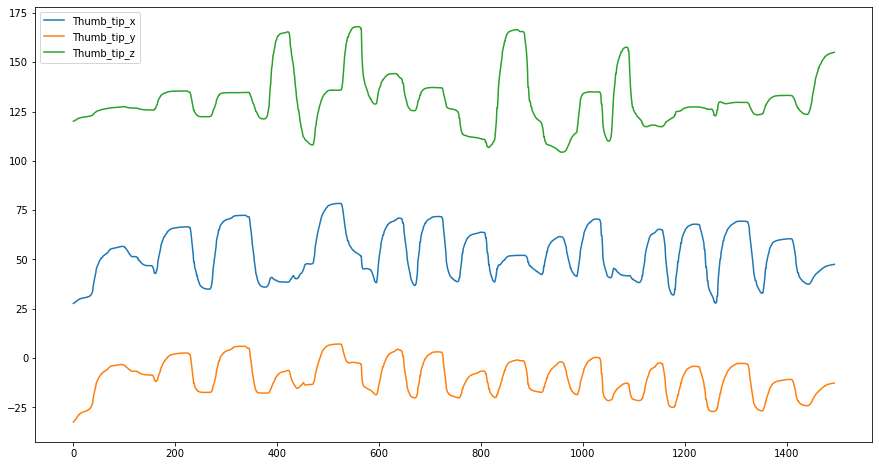

In [29]:
cols = ['Thumb_tip_x', 'Thumb_tip_y', 'Thumb_tip_z']
df = data[cols]
df.plot()

<AxesSubplot:>

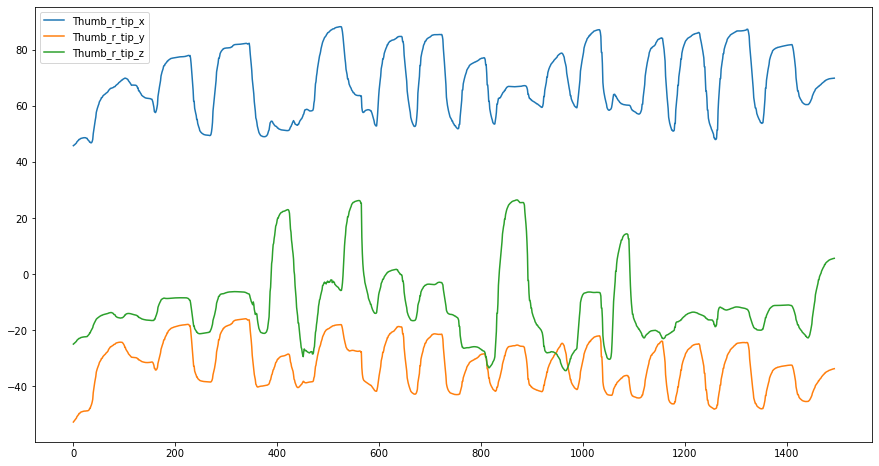

In [30]:
y.plot()

In [31]:
(df['Thumb_tip_z'] - df['Thumb_tip_y']).mean()

140.60280984070855

In [32]:
(y['Thumb_r_tip_x'] - y['Thumb_r_tip_y']).mean()

100.9797653352126

## Data preprocessing

In [33]:
from sklearn.preprocessing import MinMaxScaler

rel_hand_scaler = MinMaxScaler()
emg_scaler = MinMaxScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(X)

train_X, test_X, train_y, test_y = train_test_split(nX, ny, test_size=0.25)

In [34]:
history = NN_model.fit(train_X, train_y, epochs=500, batch_size=32, validation_split = 0.2)

Epoch 1/500
28/28 [==============================] - 0s 4ms/step - loss: 13.6506 - mean_absolute_error: 13.6506 - val_loss: 1.7355 - val_mean_absolute_error: 1.7355
Epoch 2/500
28/28 [==============================] - 0s 2ms/step - loss: 0.9203 - mean_absolute_error: 0.9203 - val_loss: 0.3234 - val_mean_absolute_error: 0.3234
Epoch 3/500
28/28 [==============================] - 0s 3ms/step - loss: 0.2999 - mean_absolute_error: 0.2999 - val_loss: 0.2796 - val_mean_absolute_error: 0.2796
Epoch 4/500
28/28 [==============================] - 0s 3ms/step - loss: 0.2359 - mean_absolute_error: 0.2359 - val_loss: 0.2470 - val_mean_absolute_error: 0.2470
Epoch 5/500
28/28 [==============================] - 0s 3ms/step - loss: 0.2276 - mean_absolute_error: 0.2276 - val_loss: 0.2147 - val_mean_absolute_error: 0.2147
Epoch 6/500
28/28 [==============================] - 0s 3ms/step - loss: 0.2139 - mean_absolute_error: 0.2139 - val_loss: 0.2268 - val_mean_absolute_error: 0.2268
Epoch 7/500
28/28 [=

Epoch 51/500
28/28 [==============================] - 0s 2ms/step - loss: 0.2109 - mean_absolute_error: 0.2109 - val_loss: 0.1940 - val_mean_absolute_error: 0.1940
Epoch 52/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1988 - mean_absolute_error: 0.1988 - val_loss: 0.2195 - val_mean_absolute_error: 0.2195
Epoch 53/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1948 - mean_absolute_error: 0.1948 - val_loss: 0.1840 - val_mean_absolute_error: 0.1840
Epoch 54/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1924 - mean_absolute_error: 0.1924 - val_loss: 0.1908 - val_mean_absolute_error: 0.1908
Epoch 55/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1908 - mean_absolute_error: 0.1908 - val_loss: 0.1834 - val_mean_absolute_error: 0.1834
Epoch 56/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1939 - mean_absolute_error: 0.1939 - val_loss: 0.2067 - val_mean_absolute_error: 0.2067
Epoch 57/500
28/

Epoch 101/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1945 - mean_absolute_error: 0.1945 - val_loss: 0.2073 - val_mean_absolute_error: 0.2073
Epoch 102/500
28/28 [==============================] - 0s 2ms/step - loss: 0.2109 - mean_absolute_error: 0.2109 - val_loss: 0.2011 - val_mean_absolute_error: 0.2011
Epoch 103/500
28/28 [==============================] - 0s 2ms/step - loss: 0.2055 - mean_absolute_error: 0.2055 - val_loss: 0.1984 - val_mean_absolute_error: 0.1984
Epoch 104/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1998 - mean_absolute_error: 0.1998 - val_loss: 0.2190 - val_mean_absolute_error: 0.2190
Epoch 105/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1928 - mean_absolute_error: 0.1928 - val_loss: 0.1857 - val_mean_absolute_error: 0.1857
Epoch 106/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1887 - mean_absolute_error: 0.1887 - val_loss: 0.2053 - val_mean_absolute_error: 0.2053
Epoch 107/

Epoch 151/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1932 - mean_absolute_error: 0.1932 - val_loss: 0.2049 - val_mean_absolute_error: 0.2049
Epoch 152/500
28/28 [==============================] - 0s 2ms/step - loss: 0.2140 - mean_absolute_error: 0.2140 - val_loss: 0.2373 - val_mean_absolute_error: 0.2373
Epoch 153/500
28/28 [==============================] - 0s 2ms/step - loss: 0.2040 - mean_absolute_error: 0.2040 - val_loss: 0.2052 - val_mean_absolute_error: 0.2052
Epoch 154/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1978 - mean_absolute_error: 0.1978 - val_loss: 0.1818 - val_mean_absolute_error: 0.1818
Epoch 155/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1991 - mean_absolute_error: 0.1991 - val_loss: 0.1989 - val_mean_absolute_error: 0.1989
Epoch 156/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1931 - mean_absolute_error: 0.1931 - val_loss: 0.1928 - val_mean_absolute_error: 0.1928
Epoch 157/

Epoch 201/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1881 - mean_absolute_error: 0.1881 - val_loss: 0.1808 - val_mean_absolute_error: 0.1808
Epoch 202/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1869 - mean_absolute_error: 0.1869 - val_loss: 0.1796 - val_mean_absolute_error: 0.1796
Epoch 203/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1901 - mean_absolute_error: 0.1901 - val_loss: 0.1807 - val_mean_absolute_error: 0.1807
Epoch 204/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1877 - mean_absolute_error: 0.1877 - val_loss: 0.1795 - val_mean_absolute_error: 0.1795
Epoch 205/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1941 - mean_absolute_error: 0.1941 - val_loss: 0.2088 - val_mean_absolute_error: 0.2088
Epoch 206/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1894 - mean_absolute_error: 0.1894 - val_loss: 0.1825 - val_mean_absolute_error: 0.1825
Epoch 207/

Epoch 251/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1946 - mean_absolute_error: 0.1946 - val_loss: 0.1927 - val_mean_absolute_error: 0.1927
Epoch 252/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1954 - mean_absolute_error: 0.1954 - val_loss: 0.2020 - val_mean_absolute_error: 0.2020
Epoch 253/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1875 - mean_absolute_error: 0.1875 - val_loss: 0.1874 - val_mean_absolute_error: 0.1874
Epoch 254/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1874 - mean_absolute_error: 0.1874 - val_loss: 0.1828 - val_mean_absolute_error: 0.1828
Epoch 255/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1899 - mean_absolute_error: 0.1899 - val_loss: 0.1829 - val_mean_absolute_error: 0.1829
Epoch 256/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1981 - mean_absolute_error: 0.1981 - val_loss: 0.1807 - val_mean_absolute_error: 0.1807
Epoch 257/

Epoch 301/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1864 - mean_absolute_error: 0.1864 - val_loss: 0.1779 - val_mean_absolute_error: 0.1779
Epoch 302/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1896 - mean_absolute_error: 0.1896 - val_loss: 0.1837 - val_mean_absolute_error: 0.1837
Epoch 303/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1904 - mean_absolute_error: 0.1904 - val_loss: 0.1799 - val_mean_absolute_error: 0.1799
Epoch 304/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1870 - mean_absolute_error: 0.1870 - val_loss: 0.1786 - val_mean_absolute_error: 0.1786
Epoch 305/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1845 - mean_absolute_error: 0.1845 - val_loss: 0.1883 - val_mean_absolute_error: 0.1883
Epoch 306/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1909 - mean_absolute_error: 0.1909 - val_loss: 0.1782 - val_mean_absolute_error: 0.1782
Epoch 307/

Epoch 351/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1842 - mean_absolute_error: 0.1842 - val_loss: 0.1761 - val_mean_absolute_error: 0.1761
Epoch 352/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1821 - mean_absolute_error: 0.1821 - val_loss: 0.1768 - val_mean_absolute_error: 0.1768
Epoch 353/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1817 - mean_absolute_error: 0.1817 - val_loss: 0.1813 - val_mean_absolute_error: 0.1813
Epoch 354/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1958 - mean_absolute_error: 0.1958 - val_loss: 0.1820 - val_mean_absolute_error: 0.1820
Epoch 355/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1867 - mean_absolute_error: 0.1867 - val_loss: 0.1762 - val_mean_absolute_error: 0.1762
Epoch 356/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1833 - mean_absolute_error: 0.1833 - val_loss: 0.1781 - val_mean_absolute_error: 0.1781
Epoch 357/

Epoch 401/500
28/28 [==============================] - 0s 4ms/step - loss: 0.1805 - mean_absolute_error: 0.1805 - val_loss: 0.1753 - val_mean_absolute_error: 0.1753
Epoch 402/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1824 - mean_absolute_error: 0.1824 - val_loss: 0.1756 - val_mean_absolute_error: 0.1756
Epoch 403/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1831 - mean_absolute_error: 0.1831 - val_loss: 0.1796 - val_mean_absolute_error: 0.1796
Epoch 404/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1841 - mean_absolute_error: 0.1841 - val_loss: 0.1749 - val_mean_absolute_error: 0.1749
Epoch 405/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1797 - mean_absolute_error: 0.1797 - val_loss: 0.1750 - val_mean_absolute_error: 0.1750
Epoch 406/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1816 - mean_absolute_error: 0.1816 - val_loss: 0.1782 - val_mean_absolute_error: 0.1782
Epoch 407/

Epoch 451/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1808 - mean_absolute_error: 0.1808 - val_loss: 0.1873 - val_mean_absolute_error: 0.1873
Epoch 452/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1813 - mean_absolute_error: 0.1813 - val_loss: 0.1761 - val_mean_absolute_error: 0.1761
Epoch 453/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1776 - mean_absolute_error: 0.1776 - val_loss: 0.1752 - val_mean_absolute_error: 0.1752
Epoch 454/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1824 - mean_absolute_error: 0.1824 - val_loss: 0.1765 - val_mean_absolute_error: 0.1765
Epoch 455/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1805 - mean_absolute_error: 0.1805 - val_loss: 0.1768 - val_mean_absolute_error: 0.1768
Epoch 456/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1789 - mean_absolute_error: 0.1789 - val_loss: 0.1757 - val_mean_absolute_error: 0.1757
Epoch 457/

By minmax scaling our input, the model mean absolute error went from 38 to 0.1756, but this is because we changed the scale of our data. We have to scale the predictions back to get an interpretable error metric.  

In [35]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

prediction = NN_model.predict(train_X) # scaled inputs here

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(train_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

MSE:  127.64997765132007
RMSE:  11.298228960829219
MAE:  8.566285168870706


In [36]:
prediction = NN_model.predict(test_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[0.5376669  0.47835237 0.3277716 ]
 [0.5156646  0.5210788  0.3116666 ]
 [0.50345534 0.5116865  0.3168804 ]
 ...
 [0.42553195 0.47391295 0.31717938]
 [0.3795099  0.54887915 0.33548725]
 [0.642426   0.7247311  0.37899226]]
MSE:  119.70666210637182
RMSE:  10.941053976028627
MAE:  8.37337411422143


In [37]:
NN_model.save("../models/BenchmarkNNRel-MinMaxScaled.h5")

However now we have saved our model, we want to be able to save our scaler too.
https://stackoverflow.com/questions/41993565/save-minmaxscaler-model-in-sklearn


In [38]:
import joblib
# Save hand scaler to file.
# Scales the output of the network, the relative position of the hand, min_max
joblib.dump(rel_hand_scaler, '../models/MinMaxRelThumb8Apr-Hand.gz')

# Scales the input to the network, the emg data. 
joblib.dump(emg_scaler, '../models/MinMaxRelThumb8Apr-EMG.gz')

['../models/MinMaxRelThumb8Apr-EMG.gz']

In [39]:
X.head(1).to_numpy()

array([[ 31, 140, 140,  83,  42,  30,  22,  21]])

In [40]:
# Making a prediction in the prediction script. 
model = load_model('../models/BenchmarkNNRel-MinMaxScaled.h5')

input_scaler = joblib.load('../models/MinMaxRelThumb8Apr-EMG.gz')
output_scaler = joblib.load('../models/MinMaxRelThumb8Apr-Hand.gz')

# Get some input data
semg_input = np.array([[ 31, 140, 140,  83,  42,  30,  22,  21]])
# Scale the input
scaled_input = input_scaler.transform(semg_input)
# Get a prediction
pred = model.predict(scaled_input)
# Scale it back to a value
scaled_pred = output_scaler.inverse_transform(pred)
scaled_pred

array([[ 58.43758 , -36.953373, -17.397673]], dtype=float32)

# So what does this model look like?

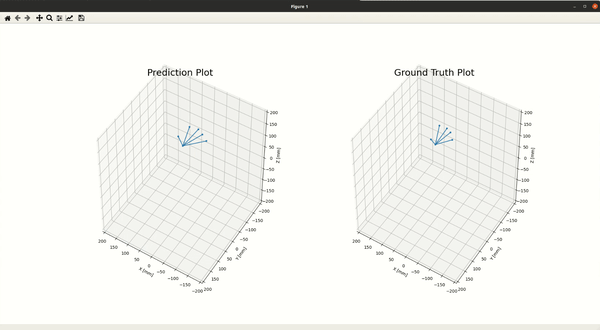

We can see it is a more stable model, and is no longer predicting the thumb to be far longer than it is, which is an improvement, however it is clear further work is needed...

## Trying alternate scaling

In [41]:
from sklearn.preprocessing import StandardScaler

rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(X)

train_X, test_X, train_y, test_y = train_test_split(nX, ny, test_size=0.25)

In [42]:
history = NN_model.fit(train_X, train_y, epochs=500, batch_size=32, validation_split = 0.2)

Epoch 1/500
28/28 [==============================] - 0s 3ms/step - loss: 0.8414 - mean_absolute_error: 0.8414 - val_loss: 0.7502 - val_mean_absolute_error: 0.7502
Epoch 2/500
28/28 [==============================] - 0s 3ms/step - loss: 0.8068 - mean_absolute_error: 0.8068 - val_loss: 0.7983 - val_mean_absolute_error: 0.7983
Epoch 3/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7721 - mean_absolute_error: 0.7721 - val_loss: 0.7372 - val_mean_absolute_error: 0.7372
Epoch 4/500
28/28 [==============================] - 0s 3ms/step - loss: 0.7683 - mean_absolute_error: 0.7683 - val_loss: 0.7441 - val_mean_absolute_error: 0.7441
Epoch 5/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7617 - mean_absolute_error: 0.7617 - val_loss: 0.7278 - val_mean_absolute_error: 0.7278
Epoch 6/500
28/28 [==============================] - 0s 3ms/step - loss: 0.7472 - mean_absolute_error: 0.7472 - val_loss: 0.7320 - val_mean_absolute_error: 0.7320
Epoch 7/500
28/28 [===

28/28 [==============================] - 0s 2ms/step - loss: 0.6597 - mean_absolute_error: 0.6597 - val_loss: 0.6953 - val_mean_absolute_error: 0.6953
Epoch 52/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6576 - mean_absolute_error: 0.6576 - val_loss: 0.6986 - val_mean_absolute_error: 0.6986
Epoch 53/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6665 - mean_absolute_error: 0.6665 - val_loss: 0.7009 - val_mean_absolute_error: 0.7009
Epoch 54/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6682 - mean_absolute_error: 0.6682 - val_loss: 0.7036 - val_mean_absolute_error: 0.7036
Epoch 55/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6655 - mean_absolute_error: 0.6655 - val_loss: 0.6955 - val_mean_absolute_error: 0.6955
Epoch 56/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6510 - mean_absolute_error: 0.6510 - val_loss: 0.7439 - val_mean_absolute_error: 0.7439
Epoch 57/500
28/28 [=========

28/28 [==============================] - 0s 2ms/step - loss: 0.6316 - mean_absolute_error: 0.6316 - val_loss: 0.7141 - val_mean_absolute_error: 0.7141
Epoch 102/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6291 - mean_absolute_error: 0.6291 - val_loss: 0.7170 - val_mean_absolute_error: 0.7170
Epoch 103/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6277 - mean_absolute_error: 0.6277 - val_loss: 0.7275 - val_mean_absolute_error: 0.7275
Epoch 104/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6300 - mean_absolute_error: 0.6300 - val_loss: 0.6994 - val_mean_absolute_error: 0.6994
Epoch 105/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6248 - mean_absolute_error: 0.6248 - val_loss: 0.6973 - val_mean_absolute_error: 0.6973
Epoch 106/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6197 - mean_absolute_error: 0.6197 - val_loss: 0.7257 - val_mean_absolute_error: 0.7257
Epoch 107/500
28/28 [===

Epoch 151/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6007 - mean_absolute_error: 0.6007 - val_loss: 0.7031 - val_mean_absolute_error: 0.7031
Epoch 152/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6003 - mean_absolute_error: 0.6003 - val_loss: 0.7080 - val_mean_absolute_error: 0.7080
Epoch 153/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6065 - mean_absolute_error: 0.6065 - val_loss: 0.7043 - val_mean_absolute_error: 0.7043
Epoch 154/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6031 - mean_absolute_error: 0.6031 - val_loss: 0.7416 - val_mean_absolute_error: 0.7416
Epoch 155/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6028 - mean_absolute_error: 0.6028 - val_loss: 0.7069 - val_mean_absolute_error: 0.7069
Epoch 156/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5972 - mean_absolute_error: 0.5972 - val_loss: 0.7107 - val_mean_absolute_error: 0.7107
Epoch 157/

Epoch 201/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5888 - mean_absolute_error: 0.5888 - val_loss: 0.7287 - val_mean_absolute_error: 0.7287
Epoch 202/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5900 - mean_absolute_error: 0.5900 - val_loss: 0.7108 - val_mean_absolute_error: 0.7108
Epoch 203/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5808 - mean_absolute_error: 0.5808 - val_loss: 0.7103 - val_mean_absolute_error: 0.7103
Epoch 204/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5722 - mean_absolute_error: 0.5722 - val_loss: 0.6984 - val_mean_absolute_error: 0.6984
Epoch 205/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5803 - mean_absolute_error: 0.5803 - val_loss: 0.7079 - val_mean_absolute_error: 0.7079
Epoch 206/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5749 - mean_absolute_error: 0.5749 - val_loss: 0.7137 - val_mean_absolute_error: 0.7137
Epoch 207/

Epoch 251/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5652 - mean_absolute_error: 0.5652 - val_loss: 0.6962 - val_mean_absolute_error: 0.6962
Epoch 252/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5570 - mean_absolute_error: 0.5570 - val_loss: 0.6979 - val_mean_absolute_error: 0.6979
Epoch 253/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5562 - mean_absolute_error: 0.5562 - val_loss: 0.7117 - val_mean_absolute_error: 0.7117
Epoch 254/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5528 - mean_absolute_error: 0.5528 - val_loss: 0.7126 - val_mean_absolute_error: 0.7126
Epoch 255/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5606 - mean_absolute_error: 0.5606 - val_loss: 0.6971 - val_mean_absolute_error: 0.6971
Epoch 256/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5543 - mean_absolute_error: 0.5543 - val_loss: 0.7008 - val_mean_absolute_error: 0.7008
Epoch 257/

Epoch 301/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5394 - mean_absolute_error: 0.5394 - val_loss: 0.7122 - val_mean_absolute_error: 0.7122
Epoch 302/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5411 - mean_absolute_error: 0.5411 - val_loss: 0.7026 - val_mean_absolute_error: 0.7026
Epoch 303/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5317 - mean_absolute_error: 0.5317 - val_loss: 0.7078 - val_mean_absolute_error: 0.7078
Epoch 304/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5386 - mean_absolute_error: 0.5386 - val_loss: 0.6979 - val_mean_absolute_error: 0.6979
Epoch 305/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5341 - mean_absolute_error: 0.5341 - val_loss: 0.6965 - val_mean_absolute_error: 0.6965
Epoch 306/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5336 - mean_absolute_error: 0.5336 - val_loss: 0.6934 - val_mean_absolute_error: 0.6934
Epoch 307/

Epoch 351/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5225 - mean_absolute_error: 0.5225 - val_loss: 0.7332 - val_mean_absolute_error: 0.7332
Epoch 352/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5173 - mean_absolute_error: 0.5173 - val_loss: 0.7150 - val_mean_absolute_error: 0.7150
Epoch 353/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5107 - mean_absolute_error: 0.5107 - val_loss: 0.7085 - val_mean_absolute_error: 0.7085
Epoch 354/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5161 - mean_absolute_error: 0.5161 - val_loss: 0.7166 - val_mean_absolute_error: 0.7166
Epoch 355/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5166 - mean_absolute_error: 0.5166 - val_loss: 0.7137 - val_mean_absolute_error: 0.7137
Epoch 356/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5104 - mean_absolute_error: 0.5104 - val_loss: 0.7073 - val_mean_absolute_error: 0.7073
Epoch 357/

Epoch 401/500
28/28 [==============================] - 0s 2ms/step - loss: 0.4981 - mean_absolute_error: 0.4981 - val_loss: 0.7439 - val_mean_absolute_error: 0.7439
Epoch 402/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5023 - mean_absolute_error: 0.5023 - val_loss: 0.7084 - val_mean_absolute_error: 0.7084
Epoch 403/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5008 - mean_absolute_error: 0.5008 - val_loss: 0.7194 - val_mean_absolute_error: 0.7194
Epoch 404/500
28/28 [==============================] - 0s 2ms/step - loss: 0.5069 - mean_absolute_error: 0.5069 - val_loss: 0.7356 - val_mean_absolute_error: 0.7356
Epoch 405/500
28/28 [==============================] - 0s 2ms/step - loss: 0.4974 - mean_absolute_error: 0.4974 - val_loss: 0.7145 - val_mean_absolute_error: 0.7145
Epoch 406/500
28/28 [==============================] - 0s 2ms/step - loss: 0.4997 - mean_absolute_error: 0.4997 - val_loss: 0.7087 - val_mean_absolute_error: 0.7087
Epoch 407/

Epoch 451/500
28/28 [==============================] - 0s 2ms/step - loss: 0.4850 - mean_absolute_error: 0.4850 - val_loss: 0.7210 - val_mean_absolute_error: 0.7210
Epoch 452/500
28/28 [==============================] - 0s 2ms/step - loss: 0.4846 - mean_absolute_error: 0.4846 - val_loss: 0.7128 - val_mean_absolute_error: 0.7128
Epoch 453/500
28/28 [==============================] - 0s 2ms/step - loss: 0.4907 - mean_absolute_error: 0.4907 - val_loss: 0.7237 - val_mean_absolute_error: 0.7237
Epoch 454/500
28/28 [==============================] - 0s 2ms/step - loss: 0.4859 - mean_absolute_error: 0.4859 - val_loss: 0.7362 - val_mean_absolute_error: 0.7362
Epoch 455/500
28/28 [==============================] - 0s 2ms/step - loss: 0.4936 - mean_absolute_error: 0.4936 - val_loss: 0.7076 - val_mean_absolute_error: 0.7076
Epoch 456/500
28/28 [==============================] - 0s 2ms/step - loss: 0.4868 - mean_absolute_error: 0.4868 - val_loss: 0.7109 - val_mean_absolute_error: 0.7109
Epoch 457/

In [43]:
prediction = NN_model.predict(train_X) # scaled inputs here

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(train_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

MSE:  79.5768292455928
RMSE:  8.920584579812738
MAE:  5.8231281903475365


In [44]:
prediction = NN_model.predict(test_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[-0.39165172 -0.44394594  0.02600107]
 [-0.06316599  0.256267   -0.01047066]
 [ 0.7296498   0.8577085  -0.2383931 ]
 ...
 [ 0.01535511 -0.09671992  0.04000571]
 [-0.80080414 -0.30108672 -0.42465118]
 [ 0.83084464  0.19645655 -0.03372112]]
MSE:  135.36499883906941
RMSE:  11.6346464853501
MAE:  8.5158853218484


## Trying alternate architectures.

In [45]:
rel_hand_scaler = MinMaxScaler()
emg_scaler = MinMaxScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(X)

train_X, test_X, train_y, test_y = train_test_split(nX, ny, test_size=0.25)

In [46]:
model = Sequential()

# The Input Layer :
model.add(Dense(256, kernel_initializer='normal',input_dim = train_X.shape[1], activation='relu'))

# The Hidden Layers :
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
model.add(Dense(3, kernel_initializer='normal',activation='linear'))

# Compile the network :
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               2304      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 771       
Total params: 134,659
Trainable params: 134,659
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.fit(train_X, train_y, epochs=500, batch_size=32, validation_split = 0.2)

Epoch 1/500
28/28 [==============================] - 0s 3ms/step - loss: 0.2672 - mean_absolute_error: 0.2672 - val_loss: 0.1927 - val_mean_absolute_error: 0.1927
Epoch 2/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1955 - mean_absolute_error: 0.1955 - val_loss: 0.1900 - val_mean_absolute_error: 0.1900
Epoch 3/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1908 - mean_absolute_error: 0.1908 - val_loss: 0.1947 - val_mean_absolute_error: 0.1947
Epoch 4/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1903 - mean_absolute_error: 0.1903 - val_loss: 0.1903 - val_mean_absolute_error: 0.1903
Epoch 5/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1896 - mean_absolute_error: 0.1896 - val_loss: 0.1930 - val_mean_absolute_error: 0.1930
Epoch 6/500
28/28 [==============================] - 0s 3ms/step - loss: 0.1875 - mean_absolute_error: 0.1875 - val_loss: 0.1941 - val_mean_absolute_error: 0.1941
Epoch 7/500
28/28 [===

28/28 [==============================] - 0s 2ms/step - loss: 0.1550 - mean_absolute_error: 0.1550 - val_loss: 0.1927 - val_mean_absolute_error: 0.1927
Epoch 52/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1590 - mean_absolute_error: 0.1590 - val_loss: 0.1767 - val_mean_absolute_error: 0.1767
Epoch 53/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1525 - mean_absolute_error: 0.1525 - val_loss: 0.1793 - val_mean_absolute_error: 0.1793
Epoch 54/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1527 - mean_absolute_error: 0.1527 - val_loss: 0.1817 - val_mean_absolute_error: 0.1817
Epoch 55/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1496 - mean_absolute_error: 0.1496 - val_loss: 0.1752 - val_mean_absolute_error: 0.1752
Epoch 56/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1525 - mean_absolute_error: 0.1525 - val_loss: 0.1795 - val_mean_absolute_error: 0.1795
Epoch 57/500
28/28 [=========

Epoch 101/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1226 - mean_absolute_error: 0.1226 - val_loss: 0.1609 - val_mean_absolute_error: 0.1609
Epoch 102/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1232 - mean_absolute_error: 0.1232 - val_loss: 0.1661 - val_mean_absolute_error: 0.1661
Epoch 103/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1205 - mean_absolute_error: 0.1205 - val_loss: 0.1633 - val_mean_absolute_error: 0.1633
Epoch 104/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1209 - mean_absolute_error: 0.1209 - val_loss: 0.1633 - val_mean_absolute_error: 0.1633
Epoch 105/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1238 - mean_absolute_error: 0.1238 - val_loss: 0.1644 - val_mean_absolute_error: 0.1644
Epoch 106/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1172 - mean_absolute_error: 0.1172 - val_loss: 0.1683 - val_mean_absolute_error: 0.1683
Epoch 107/

Epoch 151/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0970 - mean_absolute_error: 0.0970 - val_loss: 0.1648 - val_mean_absolute_error: 0.1648
Epoch 152/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0963 - mean_absolute_error: 0.0963 - val_loss: 0.1634 - val_mean_absolute_error: 0.1634
Epoch 153/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0932 - mean_absolute_error: 0.0932 - val_loss: 0.1672 - val_mean_absolute_error: 0.1672
Epoch 154/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0945 - mean_absolute_error: 0.0945 - val_loss: 0.1653 - val_mean_absolute_error: 0.1653
Epoch 155/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0966 - mean_absolute_error: 0.0966 - val_loss: 0.1646 - val_mean_absolute_error: 0.1646
Epoch 156/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0928 - mean_absolute_error: 0.0928 - val_loss: 0.1706 - val_mean_absolute_error: 0.1706
Epoch 157/

Epoch 201/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0750 - mean_absolute_error: 0.0750 - val_loss: 0.1546 - val_mean_absolute_error: 0.1546
Epoch 202/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0733 - mean_absolute_error: 0.0733 - val_loss: 0.1591 - val_mean_absolute_error: 0.1591
Epoch 203/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0738 - mean_absolute_error: 0.0738 - val_loss: 0.1623 - val_mean_absolute_error: 0.1623
Epoch 204/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0747 - mean_absolute_error: 0.0747 - val_loss: 0.1609 - val_mean_absolute_error: 0.1609
Epoch 205/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0781 - mean_absolute_error: 0.0781 - val_loss: 0.1634 - val_mean_absolute_error: 0.1634
Epoch 206/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0721 - mean_absolute_error: 0.0721 - val_loss: 0.1650 - val_mean_absolute_error: 0.1650
Epoch 207/

Epoch 251/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0577 - mean_absolute_error: 0.0577 - val_loss: 0.1568 - val_mean_absolute_error: 0.1568
Epoch 252/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0631 - mean_absolute_error: 0.0631 - val_loss: 0.1567 - val_mean_absolute_error: 0.1567
Epoch 253/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0627 - mean_absolute_error: 0.0627 - val_loss: 0.1591 - val_mean_absolute_error: 0.1591
Epoch 254/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0549 - mean_absolute_error: 0.0549 - val_loss: 0.1588 - val_mean_absolute_error: 0.1588
Epoch 255/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0576 - mean_absolute_error: 0.0576 - val_loss: 0.1588 - val_mean_absolute_error: 0.1588
Epoch 256/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0583 - mean_absolute_error: 0.0583 - val_loss: 0.1571 - val_mean_absolute_error: 0.1571
Epoch 257/

Epoch 301/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0524 - mean_absolute_error: 0.0524 - val_loss: 0.1576 - val_mean_absolute_error: 0.1576
Epoch 302/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0521 - mean_absolute_error: 0.0521 - val_loss: 0.1597 - val_mean_absolute_error: 0.1597
Epoch 303/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0470 - mean_absolute_error: 0.0470 - val_loss: 0.1611 - val_mean_absolute_error: 0.1611
Epoch 304/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0492 - mean_absolute_error: 0.0492 - val_loss: 0.1565 - val_mean_absolute_error: 0.1565
Epoch 305/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0462 - mean_absolute_error: 0.0462 - val_loss: 0.1573 - val_mean_absolute_error: 0.1573
Epoch 306/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0442 - mean_absolute_error: 0.0442 - val_loss: 0.1588 - val_mean_absolute_error: 0.1588
Epoch 307/

Epoch 351/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0397 - mean_absolute_error: 0.0397 - val_loss: 0.1552 - val_mean_absolute_error: 0.1552
Epoch 352/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0389 - mean_absolute_error: 0.0389 - val_loss: 0.1555 - val_mean_absolute_error: 0.1555
Epoch 353/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0409 - mean_absolute_error: 0.0409 - val_loss: 0.1589 - val_mean_absolute_error: 0.1589
Epoch 354/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0395 - mean_absolute_error: 0.0395 - val_loss: 0.1599 - val_mean_absolute_error: 0.1599
Epoch 355/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0406 - mean_absolute_error: 0.0406 - val_loss: 0.1527 - val_mean_absolute_error: 0.1527
Epoch 356/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0407 - mean_absolute_error: 0.0407 - val_loss: 0.1556 - val_mean_absolute_error: 0.1556
Epoch 357/

Epoch 401/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0323 - mean_absolute_error: 0.0323 - val_loss: 0.1522 - val_mean_absolute_error: 0.1522
Epoch 402/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0338 - mean_absolute_error: 0.0338 - val_loss: 0.1537 - val_mean_absolute_error: 0.1537
Epoch 403/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0335 - mean_absolute_error: 0.0335 - val_loss: 0.1548 - val_mean_absolute_error: 0.1548
Epoch 404/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.1528 - val_mean_absolute_error: 0.1528
Epoch 405/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.1579 - val_mean_absolute_error: 0.1579
Epoch 406/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0372 - mean_absolute_error: 0.0372 - val_loss: 0.1539 - val_mean_absolute_error: 0.1539
Epoch 407/

Epoch 451/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0317 - mean_absolute_error: 0.0317 - val_loss: 0.1500 - val_mean_absolute_error: 0.1500
Epoch 452/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0308 - mean_absolute_error: 0.0308 - val_loss: 0.1512 - val_mean_absolute_error: 0.1512
Epoch 453/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0296 - mean_absolute_error: 0.0296 - val_loss: 0.1484 - val_mean_absolute_error: 0.1484
Epoch 454/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0315 - mean_absolute_error: 0.0315 - val_loss: 0.1503 - val_mean_absolute_error: 0.1503
Epoch 455/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0312 - mean_absolute_error: 0.0312 - val_loss: 0.1496 - val_mean_absolute_error: 0.1496
Epoch 456/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0301 - mean_absolute_error: 0.0301 - val_loss: 0.1497 - val_mean_absolute_error: 0.1497
Epoch 457/

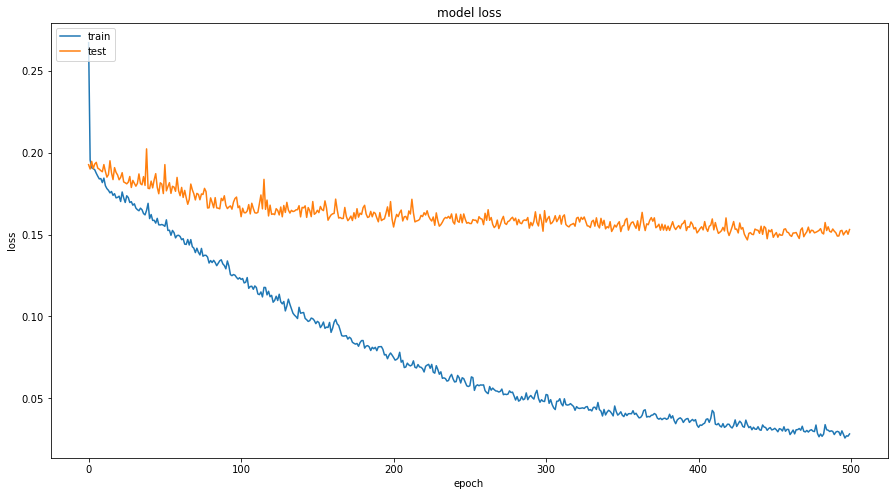

In [48]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
prediction = model.predict(train_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(train_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[0.36090505 0.53680384 0.2486242 ]
 [0.9001058  0.96788263 0.5679302 ]
 [0.85911596 0.55727917 0.3824878 ]
 ...
 [0.14494663 0.36235523 0.1852256 ]
 [0.6076773  0.56176615 0.6916705 ]
 [0.20046632 0.46586296 0.70649284]]
MSE:  24.120924823244177
RMSE:  4.911305816505848
MAE:  2.536445150583694


In [50]:
prediction = model.predict(test_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[0.8373385  0.85029614 0.44854948]
 [0.7936509  0.8620975  0.47421607]
 [0.80878586 0.60834086 0.26721013]
 ...
 [0.07712494 0.37674698 0.26010197]
 [0.75995404 0.9077133  0.45263955]
 [0.46169922 0.6609843  0.5541288 ]]
MSE:  96.73797904350806
RMSE:  9.835546707911465
MAE:  6.975111200935714


In [51]:
df_rel.shape

(1494, 11)

Given that df_rel is only 1,494 rows of data it is not worth trying to make a better model using it. 
A bigger problem I feel, is that when using animate_saved.py it is clear this dataset is not well representative of different thumb movements. 

Therefore I will make a better, more representitive dataset. 